In [1]:
from osmnx import geocode_to_gdf
from shapely.geometry import Polygon, Point, MultiPolygon, MultiPoint
from shapely.ops import unary_union, polygonize, cascaded_union
from matplotlib.pyplot import plot, figure
from math import pi, sqrt, log

In [2]:
class PolygonMetrics:
    
    def __init__(self, gdf_polygon):   
        self.polygon = self.convert_gdf_to_shapely_polygon(gdf_polygon)
        self.convex_hull_polygon = self.get_convex_hull_polygon(self.polygon) 
        self.min_rot_rect_polygon = self.get_mmr_polygon(self.convex_hull_polygon)
        self.polygon_metrics = dict()
        
    def convert_gdf_to_shapely_polygon(self, gdf_polygon):
        border_lines = unary_union(gdf_polygon.geometry.values)
        shapely_multipolygon = MultiPolygon(polygonize(border_lines))
        shapely_polygon = cascaded_union([Polygon(component.exterior).buffer(0.01).buffer(-0.01) for component in shapely_multipolygon])
        return shapely_polygon

    def get_convex_hull_polygon(self, shapely_polygon):
        multipoint_obj = MultiPoint(shapely_polygon.exterior.coords)
        convex_hull_polygon = multipoint_obj.convex_hull
        return convex_hull_polygon
    
    def get_mmr_polygon(self, convex_hull_polygon):
        return convex_hull_polygon.minimum_rotated_rectangle

    def plot_polygon(self, shapely_polygon):
        plot(*shapely_polygon.exterior.xy)        
    
    def compute_metrics(self):
        
        polygon_area = self.polygon.area
        polygon_perimeter = self.polygon.length
        
        polygon_convex_hull_area = self.convex_hull_polygon.area
        polygon_convex_hull_perimeter = self.convex_hull_polygon.length
        
        # https://stackoverflow.com/questions/13541562/python-contour-features-in-a-polygon-shapefiles-with-a-straightforward-solution
        p0 = Point(self.min_rot_rect_polygon.exterior.coords[0])
        p1 = Point(self.min_rot_rect_polygon.exterior.coords[1])
        p2 = Point(self.min_rot_rect_polygon.exterior.coords[2])
        d1 = p0.distance(p1)
        d2 = p1.distance(p2)
        polygon_major_axis_length = max(d1, d2)
        polygon_minor_axis_length = min(d1, d2)        
        polygon_contour_length = self.min_rot_rect_polygon.length       
                
        self.polygon_metrics["complexity"] = polygon_convex_hull_perimeter / polygon_perimeter
        
        self.polygon_metrics["solidity"] = polygon_area / polygon_convex_hull_area
        
        self.polygon_metrics["elongation"] = polygon_major_axis_length / polygon_minor_axis_length
        
        self.polygon_metrics["roundness"] = 4 * polygon_area / (pi * (polygon_major_axis_length ** 2))
        
        self.polygon_metrics["rectangular_fitting"] = polygon_area * ( polygon_minor_axis_length / polygon_major_axis_length) 
        
        self.polygon_metrics["compactness"] = sqrt(4 * polygon_area / pi) / polygon_contour_length
        
        self.polygon_metrics["form_factor"] = (4 * pi * polygon_area) / (polygon_perimeter ** 2)
        
        self.polygon_metrics["square_pixel_index"] = 1 - (4 * sqrt(polygon_area)) / polygon_perimeter
        
        self.polygon_metrics["fractal_dimension"] = 2 * log(polygon_perimeter / 4) / log(polygon_perimeter)
        
        self.polygon_metrics["shape_index"] = polygon_perimeter / (4 * sqrt(polygon_area))
        
        
    def get_metrics(self):
        self.compute_metrics()
        figure(figsize=(3,4))
        self.plot_polygon(self.polygon)
        self.plot_polygon(self.convex_hull_polygon)
        self.plot_polygon(self.min_rot_rect_polygon)        
        return self.polygon_metrics
   



<AxesSubplot:>

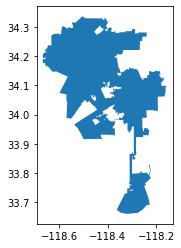

In [3]:
data_1 = geocode_to_gdf('Los Angeles, California, USA') 
data_1.plot()

{'complexity': 0.5852927673645973, 'solidity': 0.6197569237935718, 'elongation': 1.6581706102171625, 'roundness': 0.35497639082262666, 'rectangular_fitting': 0.08521355625660915, 'compactness': 0.18583011705045507, 'form_factor': 0.17328339046340305, 'square_pixel_index': 0.530285975104225, 'fractal_dimension': -0.3830019941754989, 'shape_index': 2.12895495343553}


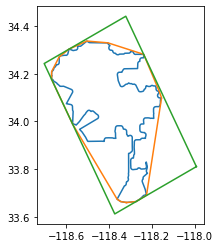

In [4]:
data_1_metrics = PolygonMetrics(data_1)
data_1_metrics_dict = data_1_metrics.get_metrics()
print(data_1_metrics_dict)